In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
import h5py
import pickle
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import G2Net2022Dataset
from tqdm.notebook import tqdm

from transforms import *
import albumentations as A

In [3]:
df = pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/train_labels.csv')
test = pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/sample_submission.csv')
df = df.loc[df['target'] != -1]

In [4]:
# v1_df = pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/v1.csv')
# v8_df = pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/v8.csv')
# v9_df = pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/v9.csv')
# v10_df = pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/v10.csv')

In [5]:
# sns.distplot(v1_df['H1_F1'])
# sns.distplot(v10_df['H1_F1'])

torch.Size([3, 360, 512])


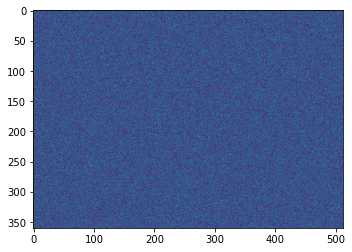

In [6]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from transforms import *

ds = G2Net2022Dataset(
    test, 
    data_dir=Path('input/g2net-detecting-continuous-gravitational-waves/test'), 
    # match_time=True,
    spec_diff=True,
    resize_factor=8, 
    transforms=A.Compose([
        # A.Resize(360, 1024), 
        ShiftImage(x_max=100, y_max=100, p=1.0),
        RandomCrop(512),
        ToTensorV2(), 
        # FrequencyMaskingTensor(p=1.0), 
        # TimeMaskingTensor(128, p=1.0),
        # FrequencyMaskingTensor(p=1.0),
        ]),
    normalize='laeyoung')
for i in range(20):
    data = ds[i][0]
    print(data.shape)
    # plt.imshow(data.permute(1,2,0)[:, :1000])
    plt.imshow(ds[i][0][0, :, :1000])
    plt.show()
    break

# Get metadata

In [5]:
# signal_summary = []
# ds = G2Net2022Dataset(df, resize_factor=4, )
# for idx in tqdm(range(len(df))):
#     try:
#         spec_h1, spec_l1 = ds[idx][0]
#     except:
#         print(f'ERROR: {idx}')
#         continue
#     signal_summary.append({
#         'idx': idx,
#         'h1_mean': spec_h1.mean().item(),
#         'h1_max': spec_h1.max().item(),
#         'h1_min': spec_h1.min().item(),
#         'l1_mean': spec_l1.mean().item(),
#         'l1_max': spec_l1.max().item(),
#         'l1_min': spec_l1.min().item()
#     })
# signal_summary = pd.DataFrame(signal_summary)


In [6]:
# signal_summary.describe()

In [90]:
def count_gaps(timestamps, Tsft=1800):
    gap_length = timestamps[1:] - (timestamps[:-1] + Tsft)
    return (gap_length > 0).sum()

In [94]:
signal_summary = []
for gid in tqdm(df['id'].values[:100]):
    fname = Path(f'input/g2net-detecting-continuous-gravitational-waves/train/{gid}.pickle')
    # with h5py.File(fname, 'r') as f:
    with open(fname, 'rb') as fp:
        f = pickle.load(fp)
        freq = list(f[gid]['frequency_Hz'])
        sig_h1, time_h1 = f[gid]['H1']['SFTs']*1e22, np.array(f[gid]['H1']['timestamps_GPS'])
        sig_l1, time_l1 = f[gid]['L1']['SFTs']*1e22, np.array(f[gid]['L1']['timestamps_GPS'])
        sig_h1 = sig_h1.real ** 2 + sig_h1.imag ** 2
        sig_l1 = sig_l1.real ** 2 + sig_l1.imag ** 2
        ts_start_h1, ts_end_h1 = time_h1[0], time_h1[-1]
        ts_start_l1, ts_end_l1 = time_l1[0], time_l1[-1]
        signal_summary.append({
            'idx': gid,
            'ts_start_h1': ts_start_h1,
            'ts_end_h1': ts_end_h1,
            'num_gaps_h1': count_gaps(time_h1),
            'length_h1': len(time_h1),
            'max_h1': np.max(sig_h1),
            '90%_h1': np.percentile(sig_h1, 90),
            '25%_h1': np.percentile(sig_h1, 25),
            '10%_h1': np.percentile(sig_h1, 10),
            'ts_start_l1': ts_start_l1,
            'ts_end_l1': ts_end_l1,
            'num_gaps_l1': count_gaps(time_l1),
            'length_l1': len(time_l1),
            'max_l1': np.max(sig_l1),
            '90%_l1': np.percentile(sig_l1, 90),
            '25%_l1': np.percentile(sig_l1, 25),
            '10%_l1': np.percentile(sig_l1, 10),
        })
signal_summary = pd.DataFrame(signal_summary)
signal_summary.describe()

In [17]:
signal_summary = []
data_df = pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/v9.csv').sample(200)
for gid in tqdm(data_df['id'].values):
    fname = Path(f'input/g2net-detecting-continuous-gravitational-waves/v9/{gid}.pickle')
    # with h5py.File(fname, 'r') as f:
    with open(fname, 'rb') as fp:
        f = pickle.load(fp)
        freq = list(f[gid]['frequency_Hz'])
        sig_h1, time_h1 = f[gid]['H1']['SFTs']*1e22, np.array(f[gid]['H1']['timestamps_GPS'])
        sig_l1, time_l1 = f[gid]['L1']['SFTs']*1e22, np.array(f[gid]['L1']['timestamps_GPS'])
        sig_h1 = sig_h1.real ** 2 + sig_h1.imag ** 2
        sig_l1 = sig_l1.real ** 2 + sig_l1.imag ** 2
        ts_start_h1, ts_end_h1 = time_h1[0], time_h1[-1]
        ts_start_l1, ts_end_l1 = time_l1[0], time_l1[-1]
        signal_summary.append({
            'idx': gid,
            'ts_start_h1': ts_start_h1,
            'ts_end_h1': ts_end_h1,
            'num_gaps_h1': count_gaps(time_h1),
            'length_h1': len(time_h1),
            'max_h1': np.max(sig_h1),
            '90%_h1': np.percentile(sig_h1, 90),
            '25%_h1': np.percentile(sig_h1, 25),
            '10%_h1': np.percentile(sig_h1, 10),
            'ts_start_l1': ts_start_l1,
            'ts_end_l1': ts_end_l1,
            'num_gaps_l1': count_gaps(time_l1),
            'length_l1': len(time_l1),
            'max_l1': np.max(sig_l1),
            '90%_l1': np.percentile(sig_l1, 90),
            '25%_l1': np.percentile(sig_l1, 25),
            '10%_l1': np.percentile(sig_l1, 10),
        })
signal_summary = pd.DataFrame(signal_summary)
signal_summary.describe()

  0%|          | 0/200 [00:00<?, ?it/s]

,ts_start_h1,ts_end_h1,num_gaps_h1,length_h1,max_h1,90%_h1,25%_h1,10%_h1,ts_start_l1,ts_end_l1,num_gaps_l1,length_l1,max_l1,90%_l1,25%_l1,10%_l1
count,2.000000e+02,2.000000e+02,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,2.000000e+02,2.000000e+02,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,1.238172e+09,1.248554e+09,307.135000,4585.820000,34.345959,5.185409,0.647685,0.237246,1.238173e+09,1.248555e+09,308.730000,4577.095000,34.214527,5.184874,0.647732,0.237282
std,6.540451e+03,2.289734e+04,15.031517,81.343478,4.870415,0.010730,0.001080,0.000631,7.464319e+03,2.287507e+04,14.874588,76.768895,5.917054,0.009487,0.001182,0.000638
min,1.238166e+09,1.248512e+09,272.000000,4382.000000,28.431526,5.161019,0.645012,0.235253,1.238166e+09,1.248502e+09,265.000000,4383.000000,28.003899,5.165280,0.644853,0.235551
25%,1.238168e+09,1.248539e+09,297.000000,4536.000000,31.557202,5.179626,0.647013,0.236830,1.238168e+09,1.248538e+09,299.000000,4524.750000,31.435245,5.179456,0.646960,0.236883
50%,1.238170e+09,1.248549e+09,306.000000,4584.500000,33.512100,5.183370,0.647723,0.237268,1.238171e+09,1.248549e+09,309.500000,4574.500000,32.990204,5.183290,0.647742,0.237332
75%,1.238174e+09,1.248565e+09,317.000000,4636.000000,35.670977,5.188011,0.648391,0.237628,1.238176e+09,1.248566e+09,319.000000,4630.000000,35.059322,5.187784,0.648361,0.237736
max,1.238202e+09,1.248649e+09,345.000000,4802.000000,72.962090,5.249333,0.651245,0.239736,1.238217e+09,1.248641e+09,346.000000,4852.000000,86.596695,5.239271,0.652471,0.239394


In [93]:
signal_summary = []
for gid in tqdm(test['id']):
    fname = Path(f'input/g2net-detecting-continuous-gravitational-waves/test/{gid}.pickle')
    # with h5py.File(fname, 'r') as f:
    with open(fname, 'rb') as fp:
        f = pickle.load(fp)
        freq = list(f[gid]['frequency_Hz'])
        sig_h1, time_h1 = f[gid]['H1']['SFTs']*1e22, np.array(f[gid]['H1']['timestamps_GPS'])
        sig_l1, time_l1 = f[gid]['L1']['SFTs']*1e22, np.array(f[gid]['L1']['timestamps_GPS'])
        sig_h1 = sig_h1.real ** 2 + sig_h1.imag ** 2
        sig_l1 = sig_l1.real ** 2 + sig_l1.imag ** 2
        ts_start_h1, ts_end_h1 = time_h1[0], time_h1[-1]
        ts_start_l1, ts_end_l1 = time_l1[0], time_l1[-1]
        signal_summary.append({
            'idx': gid,
            'ts_start_h1': ts_start_h1,
            'ts_end_h1': ts_end_h1,
            'num_gaps_h1': count_gaps(time_h1),
            'length_h1': len(time_h1),
            'max_h1': np.max(sig_h1),
            '90%_h1': np.percentile(sig_h1, 90),
            '25%_h1': np.percentile(sig_h1, 25),
            '10%_h1': np.percentile(sig_h1, 10),
            'ts_start_l1': ts_start_l1,
            'ts_end_l1': ts_end_l1,
            'num_gaps_l1': count_gaps(time_l1),
            'length_l1': len(time_l1),
            'max_l1': np.max(sig_l1),
            '90%_l1': np.percentile(sig_l1, 90),
            '25%_l1': np.percentile(sig_l1, 25),
            '10%_l1': np.percentile(sig_l1, 10),
        })
signal_summary = pd.DataFrame(signal_summary)
signal_summary.describe()

In [8]:
signal_summary.to_csv('input/signal_summary.csv', index=False)

In [110]:
signal_summary = pd.read_csv('input/signal_summary.csv')
test = pd.concat([test, signal_summary.drop('idx', axis=1)], axis=1)
test.to_csv('input/test_metadata.csv', index=False)

In [112]:
test.query('max_h1 < 60').sort_values('max_h1')

,id,target,ts_start_h1,ts_end_h1,num_gaps_h1,length_h1,max_h1,90%_h1,25%_h1,10%_h1,ts_start_l1,ts_end_l1,num_gaps_l1,length_l1,max_l1,90%_l1,25%_l1,10%_l1
301,0a2e0807c,0.5,1238170661,1248560798,315,4444,27.155708,5.193616,0.648482,0.237670,1238172517,1248544775,304,4727,31.831987,5.191594,0.647812,0.236889
2924,5e0075954,0.5,1238167849,1248546074,293,4529,27.507837,5.182478,0.647354,0.237027,1238171716,1248547474,300,4628,38.751175,5.182705,0.646806,0.237185
2176,45938c4f5,0.5,1238168050,1248533794,268,4752,27.600027,5.188679,0.647329,0.236507,1238182190,1248542809,294,4526,30.539581,5.182175,0.646983,0.238255
138,03dddf828,0.5,1238177646,1248546836,329,4581,27.733364,5.181180,0.648240,0.237757,1238176400,1248577673,294,4605,32.489426,5.175855,0.646475,0.236834
5045,a2a379a91,0.5,1238179394,1248542235,302,4562,27.779581,5.185834,0.647151,0.236552,1238167978,1248536845,283,4684,32.336845,5.174686,0.646737,0.237105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2126,441248002,0.5,1238167992,1248537550,338,4514,59.488136,8.555619,1.048718,0.384621,1238175570,1248537924,290,4648,40.239952,5.846144,0.726934,0.266724
7175,e5f7c1840,0.5,1238176496,1248559231,315,4574,59.509400,5.710221,0.698666,0.256469,1238176731,1248532361,288,4636,31.741478,4.680979,0.580917,0.212064
2836,5b10b1e61,0.5,1238169105,1248558400,328,4538,59.605915,8.132969,1.009554,0.368941,1238175497,1248583239,305,4697,37.802956,6.459987,0.802029,0.293465
3621,745ad3f49,0.5,1238172575,1248543953,313,4513,59.617702,8.884781,1.099710,0.403636,1238181628,1248602185,286,4583,42.355600,6.584819,0.817633,0.298464


/home/acb10673fd/.pyenv/versions/anaconda3-2020.02/envs/g2net2022/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

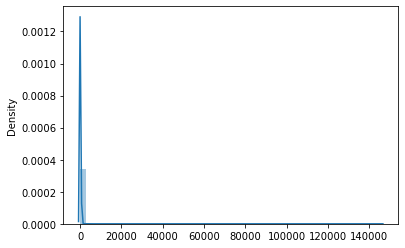

In [14]:
sns.distplot(signal_summary['max_h1'].values)

# Deal with gaps

In [6]:
# from matplotlib import colors
# from datetime import datetime


# def add_gaps(timestamps, fourier_data, Tsft):
#     gap_length = timestamps[1:] - (timestamps[:-1] + Tsft)
#     gap_data = [fourier_data[:, 0]]
#     gap_timestamps = [timestamps[0]]
#     for ind, gap in enumerate(gap_length):
#         if gap > 0:
#             gap_data.append(np.full_like(fourier_data[:, ind], np.nan + 1j * np.nan))
#             gap_timestamps.append(timestamps[ind] + Tsft)
#         gap_data.append(fourier_data[:, ind + 1])
#         gap_timestamps.append(timestamps[ind + 1])
#     return np.hstack(gap_timestamps), np.vstack(gap_data).T


# def plot_real_imag_spectrograms_with_gaps(timestamps, frequency, fourier_data, Tsft):
#     gap_timestamps, gap_data = add_gaps(timestamps, fourier_data, Tsft)
#     return plot_real_imag_spectrograms(
#         gap_timestamps, frequency, gap_data
#     )


# def plot_real_imag_spectrograms(timestamps, frequency, fourier_data):
#     fig, axs = plt.subplots(1, 2, figsize=(16, 10))

#     for ax in axs:
#         ax.set(xlabel="SFT index", ylabel="Frequency [Hz]")

#     time_in_days = (timestamps - timestamps[0]) / 1800

#     axs[0].set_title("SFT Real part")
#     c = axs[0].pcolormesh(
#         time_in_days,
#         frequency,
#         fourier_data.real,
#         norm=colors.CenteredNorm(),
#     )
#     fig.colorbar(c, ax=axs[0], orientation="horizontal", label="Fourier Amplitude")

#     axs[1].set_title("SFT Imaginary part")
#     c = axs[1].pcolormesh(
#         time_in_days,
#         frequency,
#         fourier_data.imag,
#         norm=colors.CenteredNorm(),
#     )

#     fig.colorbar(c, ax=axs[1], orientation="horizontal", label="Fourier Amplitude")

#     return fig, axs

In [1]:
# gid = df.iloc[0].id
# fname = Path('input/g2net-detecting-continuous-gravitational-waves/train')/f'{gid}.pickle'
# with open(fname, 'rb') as fp:
#     f = pickle.load(fp)
#     freq = list(f[gid]['frequency_Hz'])
#     sig_h1, time_h1 = f[gid]['H1']['SFTs'], np.array(f[gid]['H1']['timestamps_GPS'])
#     sig_l1, time_l1 = f[gid]['L1']['SFTs'], np.array(f[gid]['L1']['timestamps_GPS'])
#     print(sig_h1.shape, sig_l1.shape)
#     print(time_h1[:50] - time_l1[:50])
#     plot_real_imag_spectrograms_with_gaps(time_h1, freq, sig_h1, 1800)
#     # time_h1_true, sig_h1_true = add_gaps(time_h1, sig_h1, 1800)
#     # time_l1_true, sig_l1_true = add_gaps(time_l1, sig_l1, 1800)
#     match_idx = np.searchsorted(time_l1, time_h1) - 1
#     # print(match_idx)
#     print(time_h1[:50] - time_l1[match_idx][:50])
    

In [13]:
(time_h1[-1] - time_h1[0]) / 1800

5769.898888888889

In [14]:
# print(
#     datetime.utcfromtimestamp(time_h1_true[0]).strftime('%Y-%m-%d %H:%M:%S'),
#     datetime.utcfromtimestamp(time_h1_true[1]).strftime('%Y-%m-%d %H:%M:%S'),
#     datetime.utcfromtimestamp(time_h1_true[-1]).strftime('%Y-%m-%d %H:%M:%S')
# ), print(
#     datetime.utcfromtimestamp(time_l1_true[0]).strftime('%Y-%m-%d %H:%M:%S'),
#     datetime.utcfromtimestamp(time_l1_true[1]).strftime('%Y-%m-%d %H:%M:%S'),
#     datetime.utcfromtimestamp(time_l1_true[-1]).strftime('%Y-%m-%d %H:%M:%S')
# )

# Wave generation

In [32]:
import math
import pyfstat
from pyfstat.utils import get_sft_as_arrays
from transforms import adaptive_resize
import shutil


def bucketize_real_noise_asd(sfts, ts, buckets=256):
    bucket_size = (ts.max() - ts.min()) // buckets
    idx = np.searchsorted(ts, [ts[0] + bucket_size * i for i in range(buckets)])
    global_noise_amp = np.mean(np.abs(sfts))
    return np.array([
        np.mean(np.abs(i)) if i.shape[1] > 0 else global_noise_amp for i in np.array_split(sfts, idx[1:], axis=1)]), bucket_size


def make_signal(idx):
    # signal_depth = np.random.uniform(5, 50)
    signal_depth = 3
    signal_center = np.random.uniform(50, 500)
    noise_kwargs_h1 = {
        "outdir": 'pyfstat',
        "label": f'signal{idx}_h1',
        "duration": 4 * 30 * 86400,
        "tstart": 1238168771,
        "Tsft": 1800,
        "detectors": "H1",
        "sqrtSX": 1e-23,
        "SFTWindowType": "tukey",
        "SFTWindowBeta": 0.01,
        "Band": 0.4,
    }
   
    signal_kwargs_h1 = {
        "F0": signal_center,
        "F1": -1e-10,
        "F2": 0,
        "Alpha": np.random.uniform(0, math.pi * 2),
        "Delta": np.random.uniform(-math.pi/2, math.pi/2),
        "h0": noise_kwargs_h1['sqrtSX'] / signal_depth,
        "cosi": np.random.uniform(-1, 1),
        "psi": np.random.uniform(-math.pi/4, math.pi/4),
        "phi": np.random.uniform(0, math.pi*2),
    }

    writer_h1 = pyfstat.Writer(**noise_kwargs_h1, **signal_kwargs_h1)
    writer_h1.make_data()
   
    freqs_h1, times_h1, sft_data_h1 = get_sft_as_arrays(writer_h1.sftfilepath)
    return sft_data_h1
    

In [36]:
# trns = A.Compose([ToSpectrogram(), AdaptiveResize(8)])
# sft = trns(image=sft['H1'][:, :, None])['image']
# plt.imshow(sft)

# Model

In [18]:
# from replknet import create_RepLKNet31B, create_RepLKNet31L
# from kuma_utils.torch.utils import fit_state_dict
# import torch

In [27]:
# model = create_RepLKNet31B(in_chans=2, num_classes=1)

In [25]:
# checkpoint = torch.load('input/RepLKNet-31B_ImageNet-22K-to-1K_384.pth')
# fit_state_dict(checkpoint, model)
# model.load_state_dict(checkpoint, strict=False)

Size mismatch in stem.0.conv.weight: torch.Size([128, 3, 3, 3]) -> torch.Size([128, 2, 3, 3])
Size mismatch in head.weight: torch.Size([1000, 1024]) -> torch.Size([1, 1024])
Size mismatch in head.bias: torch.Size([1000]) -> torch.Size([1])
